# Colour map

to make the episode descriptions as generic as possible, we'll map each character in each season to a generic colour label, allowing for interchangability. 

steps involved:
1. scrape characters / power ranger names
2. extract colours from the power ranger names
3. assign colours to some of the weird ones as I deffo saw some power rangers called like 'phantom' which isnt a colour and isnt helpful
4. probs also take characters first names as an extra column too.

In [73]:
import pandas as pd
from colour import Color
from typing import Optional, Dict, List
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

so lets get started by readin in the scraped data and seeing where we stand

In [18]:
df = pd.read_excel('data/colour_list.xlsx')
df.head()

,Color,Role,Actor,season
0,Red Ranger,Jason Lee Scott,Austin St. John,mighty morphin
1,Black Ranger,Zack Taylor,Walter Jones,mighty morphin
2,Blue Ranger,Billy Cranston,David Yost,mighty morphin
3,Yellow Ranger,Trini Kwan,Thuy Trang,mighty morphin
4,Pink Ranger,Kimberly Ann Hart,Amy Jo Johnson,mighty morphin


we'll start with some quick housekeeping, namely some decapitalising, prehaps a column rename or two...

In [19]:
df.columns = [column.lower() for column in df.columns]
df.rename(columns={'color': 'raw_colour'}, inplace=True)

df['raw_colour'] = df['raw_colour'].str.lower()
df['character'] = df['role'].str.split().str[0]

df.head()

,raw_colour,role,actor,season,character
0,red ranger,Jason Lee Scott,Austin St. John,mighty morphin,Jason
1,black ranger,Zack Taylor,Walter Jones,mighty morphin,Zack
2,blue ranger,Billy Cranston,David Yost,mighty morphin,Billy
3,yellow ranger,Trini Kwan,Thuy Trang,mighty morphin,Trini
4,pink ranger,Kimberly Ann Hart,Amy Jo Johnson,mighty morphin,Kimberly


fab. Next I'll extract the colours where they exist...

In [24]:
def check_color(word: str) -> bool:
    """Checks if a word is a colour.
    
    Parameters
    ----------
    word : Input word to be checked.
    
    Returns
    -------
    bool
        True or False respectively.
    """
    try:
        Color(word)
        return True
    except ValueError:
        return False
    

def find_colour_in_text(input_text: str) -> Optional[str]:
    """Extract the colour from a given string
    
    Parameters
    ----------
    input_text : String ideally containing some colour.
    
    Returns
    -------
    str
        The colour contained in input_text, else None
    """
    colour_list = [i for i in input_text.split(' ') if check_color(i)]
    
    if len(colour_list) > 0:
        return colour_list[0]
    else:
        return input_text.replace(' ranger', '')  # mostly these are 'quantumn ranger', or 'deka ranger'.

df['colour'] = df['raw_colour'].apply(find_colour_in_text)
df['colour_ranger'] = df['colour'] + ' ranger'
df.head()

,raw_colour,role,actor,season,character,colour,colour_ranger
0,red ranger,Jason Lee Scott,Austin St. John,mighty morphin,Jason,red,red ranger
1,black ranger,Zack Taylor,Walter Jones,mighty morphin,Zack,black,black ranger
2,blue ranger,Billy Cranston,David Yost,mighty morphin,Billy,blue,blue ranger
3,yellow ranger,Trini Kwan,Thuy Trang,mighty morphin,Trini,yellow,yellow ranger
4,pink ranger,Kimberly Ann Hart,Amy Jo Johnson,mighty morphin,Kimberly,pink,pink ranger


fabulous. I think we are now ready to progress to scraping episode synopsis' for every episode, whereafter we can hopefully use this data to replace any mentions of characters / colours with the simplified versions. its highly likely we'll need to come back and do some further tweaking later but for now this will work :)

In [25]:
df.to_csv('data/colours_cleaned', index=False)

# Series descriptions

next up, web scraped season descriptions. Ideally we would want to clean these so that the 'season' name matches the format of the one in the colours_cleaned data.

In [11]:
df = pd.read_json('data/powerrangers-wiki_series.json')
df.head()

,date_scraped,series,series_synopsis,time_scraped
0,14062021,Power Rangers Dino Thunder,"A soccer player, computer expert, a musician, ...",213005
1,14062021,Mighty Morphin Power Rangers (Season 2),Angered at the repeated failures of his servan...,213005
2,14062021,Power Rangers Lost Galaxy,"In late 1998, after Power Rangers in Space end...",213005
3,14062021,Power Rangers Dino Fury,"On February 22, 2020, Hasbro revealed at New Y...",213005
4,14062021,Power Rangers Mystic Force,"A short time ago, there was a dimension filled...",213005


safe so:
1. drop the date / time scraped variables as forgot I'd asked to add those on from the scraper (have they ever been useful?)
2. lower case the series
3. remove 'power rangers' from the series
4. I guess remove (season \*) as well

see if that deos the trick

In [12]:
df.drop(['date_scraped', 'time_scraped'], inplace=True, axis=1)

df['series'] = df['series'].str.lower()
df['series'] = df['series'].str.replace('power rangers', '')
df['series'] = df['series'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))

df.rename(columns={'series': 'season'}, inplace=True)

df.head()

,season,series_synopsis
0,dino thunder,"A soccer player, computer expert, a musician, ..."
1,mighty morphin,Angered at the repeated failures of his servan...
2,lost galaxy,"In late 1998, after Power Rangers in Space end..."
3,dino fury,"On February 22, 2020, Hasbro revealed at New Y..."
4,mystic force,"A short time ago, there was a dimension filled..."


Now that is incredibly norty. save it away for a rainy day

In [13]:
df.to_csv('data/series_description.csv', index=False)

# Episodes cleaning

finally for this initial cleaning and prep stage thing part, lets whack out the episodes data and make a riteous mess...

In [14]:
df = pd.read_json('data/powerrangers-wiki_episodes.json')
df.head()

,date_scraped,episode_synopsis,series,time_scraped,url
0,14062021,While on a detention-related field trip with t...,"Power Rangers Dino Thunder, Episode 12x01, 12x02",213006,https://powerrangers.fandom.com/wiki/Day_of_th...
1,14062021,Rita Repulsa has been removed from power and n...,"Mighty Morphin Power Rangers (Season 2), Episo...",213006,https://powerrangers.fandom.com/wiki/The_Mutiny
2,14062021,"With Dr. Oliver ""on sick leave"" (due to his de...","Dino Thunder, Episode 12x17",213006,https://powerrangers.fandom.com/wiki/The_Missi...
3,14062021,As Trent has been completely taken over by the...,"Power Rangers Dino Thunder, Episode 12x16",213006,https://powerrangers.fandom.com/wiki/Burning_a...
4,14062021,A meteor's energy changes the Rangers' persona...,"Power Rangers Dino Thunder, Episode 12x15",213006,https://powerrangers.fandom.com/wiki/Leader_of...


yet again with the bloody date / time scraped dammit need to be more on the ball with accepting that hahaha.

that aside, a few meanignful things can be extracted here, namely:
- episode name from the url
- episode number from series
- season from series
I assume the episode descriptions will hold.

In [20]:
df['episode_name'] = df['url'].str.split('/').str[-1]
df['episode_name'] = df['episode_name'].str.replace('_', ' ').str.lower()

df['episode_number'] = df['series'].apply(lambda x: re.compile('x([0-9]*)').findall(x))

df['series'] = df['series'].str.lower()
df['series'] = df['series'].str.replace('power rangers', '')
df['series'] = df['series'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
df['series'] = df['series'].str.split(',').str[0]
df['series'] = df['series'].str.lstrip().str.rstrip()
df['series'] = df['series'].str.replace('super ', '').str.replace('.', '')

df.rename(columns={'series': 'season'}, inplace=True)
df.drop(['date_scraped', 'time_scraped', 'url'], inplace=True, axis=1)

df.head()

,episode_synopsis,season,episode_name,episode_number
0,While on a detention-related field trip with t...,dino thunder,day of the dino,"[01, 02]"
1,Rita Repulsa has been removed from power and n...,mighty morphin,the mutiny,"[01, 02, 03]"
2,"With Dr. Oliver ""on sick leave"" (due to his de...",dino thunder,the missing bone,[17]
3,As Trent has been completely taken over by the...,dino thunder,burning at both ends,[16]
4,A meteor's energy changes the Rangers' persona...,dino thunder,leader of the whack,[15]


safety. Aight this makes it done for now, next up, will be engineering these into some cool unified dataset 

In [22]:
df.to_csv('data/episode_descriptions.csv', index=False)

# Unifying the descriptions

so, steps here will be tooken to try and lie our way into making the episodes all about the same cast:

1. replace all mention of the characters with their colours
2. replace all mention of the weirdly specific colours with the unified colours
3. i guess just be amazed or something...

In [24]:
colours = pd.read_csv('data/colours_cleaned.csv')
episodes = pd.read_csv('data/episode_descriptions.csv')

I guess the first step is to try and form the colours dataframe into something more useful...

In [25]:
colours['str_map'] = (colours['raw_colour'] + ',' + 
                      colours['role'] + ',' + 
                      colours['character'])
colours = colours.groupby(['season', 'colour_ranger'])['str_map'].apply(lambda x : ', '.join(x)).reset_index()
colours['str_map'] = colours['str_map'].str.split(',')
colours = colours.pivot(index='season', columns='colour_ranger', values='str_map').reset_index()
#  for seasons where multiple characters share a colour, the above code merges them into a single value then pivots

sick okie dokie, I guess the jist of the plan is to now join this via 'season' to episodes and then use the columns as paint by numbers to replace the appearing words with the generic colours. There are far more varieties than i realised to be perfectly honest (i.e. 'grey ranger', 'navy ranger', etc...) but I'm hopeful it'll at least be decent. 

In [26]:
df = pd.merge(episodes, colours, on='season', how='left')

df.head()

,episode_synopsis,season,episode_name,episode_number,aqua ranger,black ranger,blue ranger,crimson ranger,cyan ranger,gold ranger,...,orange ranger,phantom ranger,pink ranger,purple ranger,quantum ranger,red ranger,silver ranger,titanium ranger,white ranger,yellow ranger
0,While on a detention-related field trip with t...,dino thunder,day of the dino,"['01', '02']",NaN,"[black dino ranger, Tommy Oliver, Tommy]","[blue dino ranger, Ethan James, Ethan]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[red dino ranger, Conner McKnight, Conner]",NaN,NaN,"[white dino ranger, Trent Fernandez-Mercer, Tr...","[yellow dino ranger, Kira Ford, Kira]"
1,Rita Repulsa has been removed from power and n...,mighty morphin,the mutiny,"['01', '02', '03']",NaN,"[black ranger, Zack Taylor, Zack, black range...","[blue ranger, Billy Cranston, Billy, blue ran...",NaN,NaN,NaN,...,NaN,NaN,"[pink ranger, Kimberly Ann Hart, Kimberly, pi...",NaN,NaN,"[red ranger, Jason Lee Scott, Jason, red rang...",NaN,NaN,"[white ranger, Tommy Oliver, Tommy, white (ni...","[yellow ranger, Trini Kwan, Trini, yellow ran..."
2,"With Dr. Oliver ""on sick leave"" (due to his de...",dino thunder,the missing bone,['17'],NaN,"[black dino ranger, Tommy Oliver, Tommy]","[blue dino ranger, Ethan James, Ethan]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[red dino ranger, Conner McKnight, Conner]",NaN,NaN,"[white dino ranger, Trent Fernandez-Mercer, Tr...","[yellow dino ranger, Kira Ford, Kira]"
3,As Trent has been completely taken over by the...,dino thunder,burning at both ends,['16'],NaN,"[black dino ranger, Tommy Oliver, Tommy]","[blue dino ranger, Ethan James, Ethan]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[red dino ranger, Conner McKnight, Conner]",NaN,NaN,"[white dino ranger, Trent Fernandez-Mercer, Tr...","[yellow dino ranger, Kira Ford, Kira]"
4,A meteor's energy changes the Rangers' persona...,dino thunder,leader of the whack,['15'],NaN,"[black dino ranger, Tommy Oliver, Tommy]","[blue dino ranger, Ethan James, Ethan]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[red dino ranger, Conner McKnight, Conner]",NaN,NaN,"[white dino ranger, Trent Fernandez-Mercer, Tr...","[yellow dino ranger, Kira Ford, Kira]"


ok ok, so we've successfully gotten some of our shit together, but there are a ouple of forseen issues, most notably that for any season with like returning characters, those characters will not be mapped to their generic names and I guess will instead appear as if any other side characters.

I wonder if i should also map mentor characters to 'mentor' so that they stay consistant too?

who knows. For now, we need to do a row by row fairly fiddlesome regex replace I think. unless theres an easier way?

In [27]:
def get_dict_from_cols(input_df: pd.Series) -> Dict[str, List[str]]:
    """Convert row of pandas data to a dictionary with no nan vaues.
    
    Parameters
    ----------
    target_df : A row of pandas data with some column names to act as keys
    
    Returns
    -------
    Dict[str, List[str]]
        Dictionary equivalent of the non null cells in target_df
    """
    input_df = input_df.reset_index().dropna()
    input_df.columns = ['colour', 'keywords']
    output_dict = dict(zip(input_df['colour'], input_df['keywords']))
    
    return output_dict


def find_replace_colours(input_string: str,
                         target_df: pd.Series,
) -> str:
    """Terrible implementation of a poor idea.
    
    Parameters
    ----------
    input_string : The string to be manipulated.
    target_dict : The columns to map.
    
    Returns
    -------
    str
        The string post manipulation.
    """
    map_dict = get_dict_from_cols(target_df)
    
    for key, value in map_dict.items():
        for keyword in value:
            input_string = input_string.replace(keyword, key)
            
    return input_string


not_rangers = ['episode_synopsis', 'season', 'episode_name', 'episode_number']
rangers = [column for column in df.columns if column not in not_rangers]

df['episode_synopsis_colour_mapped'] = df.apply(lambda x: find_replace_colours(x['episode_synopsis'],
                                                                               x[rangers]),
                                                axis=1)

df['episode_synopsis_colour_mapped'][0]

"While on a detention-related field trip with their new science teacher (Dr. black ranger), three students from Reefside High School (soccer star red ranger, rocker star wannabe yellow ranger, and wiz-kid blue ranger), stumble upon mystical Dino Gems which give them special powers. This makes them a target for a group of evil creatures known as Tyrannodrones. Can the teen trio work together despite their vast differences? And what connection is there between Dr. Oliver and the T-Drones's master, the dinosauric humanoid known as Mesogog? , yellow ranger must escape from Mesogog's island base, while being chased by the Tyranodrones and henchmen Elsa & Zeltrax. With help from Dr. black ranger, red ranger & blue ranger come to her aid. Their new science teacher reveals his connection to Mesogog and company, and to help combat this evil force, gives the three Dino Morphers to harness the Dino Gems, allowing them to become Dino Thunder Power Rangers! When Mesogog releases the three brainwash

'dr black ranger' lol.

otherwise seems aight i guess? It ran pretty quick supprisingly too.

guess I'll take it for now lol. So next steps will be to start EDA

In [48]:
df.to_csv('data/colour_mapped_episodes.csv', index=False)

# EDA

we'll start with some really basic stuff I guess. to keep relatively on track, I'd like to:

1. get a feel for coverage
2. get a feel for how frequently individual colours get personal stories
3. get a feel for frequency of each colour in the synopsis'
4. word clouds per season, likely with the colours removed

<AxesSubplot:>

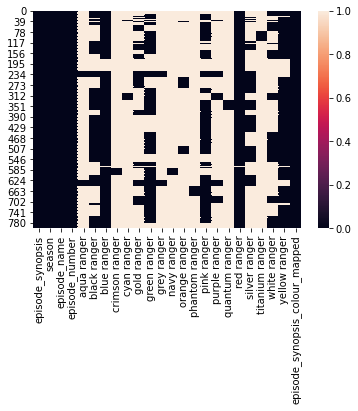

In [40]:
sns.heatmap(df.isnull())

we dont need thos columns anymore anyways, lets drop them all going forwards:

<AxesSubplot:>

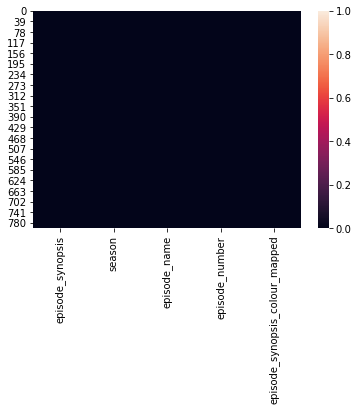

In [47]:
df.drop(columns=rangers, inplace=True)

sns.heatmap(df.isnull())

perfect. next up, lets go looking for those one ranger episodes...

In [54]:
for ranger in rangers:
    df[ranger] = np.where(df['episode_synopsis_colour_mapped'].str.contains(ranger), 1, 0)

df['number_of_rangers_in_ep'] = df[rangers].sum(axis=1)
df['lone_ranger'] = df[rangers].apply(lambda x: x.idxmax(), axis=1)
df['lone_ranger'] = np.where(df['number_of_rangers_in_ep'] == 1, df['lone_ranger'], None)  # is there no one liner for this?
df.head()

,episode_synopsis,season,episode_name,episode_number,episode_synopsis_colour_mapped,aqua ranger,black ranger,blue ranger,crimson ranger,cyan ranger,...,pink ranger,purple ranger,quantum ranger,red ranger,silver ranger,titanium ranger,white ranger,yellow ranger,number_of_rangers_in_ep,lone_ranger
0,While on a detention-related field trip with t...,dino thunder,day of the dino,"['01', '02']",While on a detention-related field trip with t...,0,1,1,0,0,...,0,0,0,1,0,0,0,1,4,None
1,Rita Repulsa has been removed from power and n...,mighty morphin,the mutiny,"['01', '02', '03']",Rita Repulsa has been removed from power and n...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,"With Dr. Oliver ""on sick leave"" (due to his de...",dino thunder,the missing bone,['17'],"With Dr. Oliver ""on sick leave"" (due to his de...",0,1,0,0,0,...,0,0,0,0,0,0,1,1,3,None
3,As Trent has been completely taken over by the...,dino thunder,burning at both ends,['16'],As white ranger has been completely taken over...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,white ranger
4,A meteor's energy changes the Rangers' persona...,dino thunder,leader of the whack,['15'],A meteor's energy changes the Rangers' persona...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,2,None


interesting to see an episode with 0 rangers right from the start lol immediate shocker. otherwise though this seems to have worked and we can have a look at how many we've got fairly easily...

In [62]:
df[df['number_of_rangers_in_ep'] == 0]['episode_synopsis_colour_mapped'][1]

'Rita Repulsa has been removed from power and now her master, Lord Zedd threatens the Earth with powers unlike anything ever seen before. He creates the Pirantishead monster who freezes four of the Dinozords and took control of the Tyrannosaurus and Dragonzord. The Power Rangers must step up their game if they hope to survive against this new enemy.'

ok this is no biggy at all whatsoever. how many episodes have a lone ranger ridin' through an open plane?

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 799
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   episode_synopsis                799 non-null    object
 1   season                          799 non-null    object
 2   episode_name                    800 non-null    object
 3   episode_number                  800 non-null    object
 4   episode_synopsis_colour_mapped  799 non-null    object
 5   aqua ranger                     800 non-null    int32 
 6   black ranger                    800 non-null    int32 
 7   blue ranger                     800 non-null    int32 
 8   crimson ranger                  800 non-null    int32 
 9   cyan ranger                     800 non-null    int32 
 10  gold ranger                     800 non-null    int32 
 11  green ranger                    800 non-null    int32 
 12  grey ranger                     800 non-null    in

only 350? damn son. At least those can be labeled as like personal episodes for those particular rangers. to find most commonly appearing solo players we can now just do some colsums

In [74]:
px.bar(pd.DataFrame(df[rangers].sum()).sort_values(by=0))

unsupprisingly its red who shows up most frequently. interesting to see gold ranger overtake silver too as when i was young i swear there was never a gold one but often times thered be silver.

dunno what aqua and cyan are playing at tbh, maybe if they teamed up as the pale blue rangers theyd get some more hits.

Id like to plot a similar graph just for the individual story episodes now, to see how red bias that is...

In [79]:
px.bar(df['lone_ranger'].value_counts())

shit son. supprised yellow isnt the third as id always assumed red blue and yellow were the main characters due to being primary colours. i am noticing prehaps a cleaning error here where 'titanium ranger' has slipped through the cracks despite being silver in colour... to be honest im wondering with these more niche colours if i should look to make them into like a single 'bonus ranger' or something but guess we'll see how it goes without that first.